In [416]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from functools import partial

from sklearn.datasets import make_hastie_10_2, make_classification
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, average_precision_score, recall_score, precision_recall_curve, classification_report
from sklearn.ensemble import RandomForestClassifier

# Metrics to measure
- Overall F1 Score
- Precision @0.1 increments of probability
- Recall @0.1 increments of probability
- Count trades @0.1 increments of probability
- Mean trade returns @0.1 increments of probability
- 25/50/75 percentile trade returns @0.1 increments of probability
- min/max @0.1 increments of probability
- cum prod returns (from 1.0 to 0.0) @0.1 increments of probability (based on last value in window)
- threshold that reflects max cum prod returns

In [434]:
X, y = make_classification(n_samples=2000, n_features=10, n_informative=5, n_classes=2)

In [435]:
col_names = ["gfs", "gh", "lo", "we", "cv", "az", "my", "qd", "xf", "ie"]

In [436]:
X = pd.DataFrame(X, columns=col_names)
y = pd.Series(y)

In [437]:
y

0       0
1       1
2       1
3       0
4       1
       ..
1995    0
1996    0
1997    1
1998    1
1999    1
Length: 2000, dtype: int64

In [429]:
returns = pd.DataFrame(np.random.random(size=len(X))/10 - 0.05, columns=["returns"], index=X.index)
returns

,returns
0,-0.004932
1,0.022872
2,-0.040241
3,0.012615
4,-0.018734
...,...
1995,-0.028416
1996,0.002010
1997,0.014086
1998,-0.017134


In [430]:
returns_df = pd.DataFrame(index=returns.index)
returns_df["returns_long"] = returns + 1.0
returns_df["returns_short"] = -returns + 1.0
returns_df

,returns_long,returns_short
0,0.995068,1.004932
1,1.022872,0.977128
2,0.959759,1.040241
3,1.012615,0.987385
4,0.981266,1.018734
...,...,...
1995,0.971584,1.028416
1996,1.002010,0.997990
1997,1.014086,0.985914
1998,0.982866,1.017134


In [439]:
y = y.map({0: "loss", 1: "win"})
y

0       loss
1        win
2        win
3       loss
4        win
        ... 
1995    loss
1996    loss
1997     win
1998     win
1999     win
Length: 2000, dtype: object

In [203]:
def get_mc_threshold_max_cumprod_returns_2(estimator, X, y, returns_df, target):

    if target in estimator.classes_:
        
        # Get df with proba and returns
        df = get_predictions_with_returns(estimator, X, returns_df, target)
        
        # Print trade and cumprod returns descriptions
        log_return_description(df)
        
        # Print threshold and max value
        log_threshold_max_cumprod_returns(df)
        log_value_max_cumprod_returns(df)
        
        return 1
    else:
        return -999

def get_predictions_with_returns(estimator, X, returns_df, target):
    X_copy = X.copy()
    class_idx = estimator.classes_.tolist().index(target)

    # Add target prediction probabilities to df
    X_copy["pred_proba"] = np.float64(estimator.predict_proba(X_copy)[:, class_idx])

    # Add returns to df
    if "short" in target:
        return_col = "returns_short"
    elif "long" in target:
        return_col = "returns_long"
    else:
        return -999

    X_copy["returns"] = returns_df.loc[:, return_col]
    X_copy = X_copy.sort_values(by="pred_proba", ascending=False)
    X_copy["cumprod_returns"] = X_copy["returns"].cumprod()

    return X_copy

def log_return_description(df):
    bins = np.linspace(start=0, stop=1, num=11)
    stats = df[["cumprod_returns", "returns"]].groupby(
        pd.cut(df["pred_proba"], bins=bins)).agg(["mean", "min", "max"])
    print(stats)
    
def log_threshold_max_cumprod_returns(df):
    max_cumprod_returns_idx = df["cumprod_returns"].argmax()
    max_cumprod_returns_threshold = df.iloc[max_cumprod_returns_idx]["pred_proba"]
    print(f"max_cumprod_returns_threshold: {max_cumprod_returns_threshold}")
    
def log_value_max_cumprod_returns(df):
    max_cumprod_returns_idx = df["cumprod_returns"].argmax()
    max_cumprod_returns_value = df.iloc[max_cumprod_returns_idx]["cumprod_returns"]
    print(f"max_cumprod_returns_value: {max_cumprod_returns_value}")

In [446]:
pos_label = "win"

mc_scores = {
    "value_meta_f1_score": make_scorer(
        f1_score, pos_label=pos_label, average="binary"),
    "value_f1_macro_score": make_scorer(
        f1_score, average="macro"),
    "value_roc_score": make_scorer(
        roc_auc_score, needs_proba=True),
}

In [447]:
cv = KFold(2)
clf = RandomForestClassifier()
cross_validate(estimator=clf, X=X, y=y, scoring=mc_scores, cv=cv)

{'fit_time': array([0.127244  , 0.11006498]),
 'score_time': array([0.02132988, 0.02175713]),
 'test_value_meta_f1_score': array([0.93983402, 0.94255112]),
 'test_value_f1_macro_score': array([0.94192473, 0.94095696]),
 'test_value_roc_score': array([0.98114556, 0.98539424])}

In [88]:
a = [1,2,3,4]
a.index(2)

1

In [54]:
def get_mc_describe_returns(estimator, X, y, returns_df, title):
    classes_to_describe = [c for c in estimator.classes_ if c not in ["loss", "not_minmax_slow"]]
    for idx, c in enumerate(classes_to_describe):
        X_copy = X.copy()
        X_copy["pred_proba"] = estimator.predict_proba(X_copy)[:, idx]

        if "short" in c:
            return_col = "returns_short"
        else:
            return_col = "returns_long"

        returns = returns_df.loc[X_copy.index, return_col]
        bins = np.linspace(start=0, stop=1, num=11)
        stats = returns.groupby(pd.cut(X_copy["pred_proba"], bins=bins)).agg("describe")
        print(f"Trade Returns by Threshold: {title} ({c})")
        print(stats)

    return 0


def get_mc_describe_cumprod_returns(estimator, X, y, returns_df, title):
    classes_to_describe = [c for c in estimator.classes_ if c not in ["loss", "not_minmax_slow"]]
    for idx, c in enumerate(classes_to_describe):
        X_copy = X.copy()
        X_copy["pred_proba"] = estimator.predict_proba(X_copy)[:, idx]
        X_copy = X_copy.sort_values(by="pred_proba", ascending=False)

        if "short" in c:
            return_col = "returns_short"
        else:
            return_col = "returns_long"

        returns = returns_df.loc[X_copy.index, return_col]
        X_copy["cumprod_returns"] = returns.cumprod()

        bins = np.linspace(start=0, stop=1, num=11)
        stats = X_copy["cumprod_returns"].groupby(
            pd.cut(X_copy["pred_proba"], bins=bins)).agg("describe")
        print(f"Cumulative Product Returns by Threshold: {title} ({c})")
        print(stats)

    return 0


def get_mc_threshold_max_cumprod_returns(estimator, X, y, returns_df, target):
    classes_to_describe = [c for c in estimator.classes_]
    for idx, c in enumerate(classes_to_describe):

        if target == c:
            X_copy = X.copy()
            X_copy["pred_proba"] = estimator.predict_proba(X_copy)[:, idx]
            X_copy = X_copy.sort_values(by="pred_proba", ascending=False)

            if "short" in c:
                return_col = "returns_short"
            else:
                return_col = "returns_long"

            returns = returns_df.loc[X_copy.index, return_col]
            X_copy["cumprod_returns"] = returns.cumprod()

            max_cumprod_returns_idx = X_copy["cumprod_returns"].argmax()
            max_cumprod_returns_threshold = X_copy.iloc[max_cumprod_returns_idx]["pred_proba"]

            return max_cumprod_returns_threshold
        else:
            # Loop through remaining classes
            continue

    return -999


def get_mc_value_max_cumprod_returns(estimator, X, y, returns_df, target):
    classes_to_describe = [c for c in estimator.classes_]
    for idx, c in enumerate(classes_to_describe):

        if target == c:
            X_copy = X.copy()
            X_copy["pred_proba"] = estimator.predict_proba(X_copy)[:, idx]
            X_copy = X_copy.sort_values(by="pred_proba", ascending=False)

            if "short" in c:
                return_col = "returns_short"
            else:
                return_col = "returns_long"

            returns = returns_df.loc[X_copy.index, return_col]
            X_copy["cumprod_returns"] = returns.cumprod()

            max_cumprod_returns_idx = X_copy["cumprod_returns"].argmax()
            max_cumprod_returns_value = X_copy.iloc[max_cumprod_returns_idx]["cumprod_returns"]

            return max_cumprod_returns_value
        else:
            # Loop through remaining classes
            continue

    return -999

def get_mc_describe_precision_recall(estimator, X, y, title):
    classes_to_describe = [c for c in estimator.classes_ if c not in ["loss", "not_minmax_slow"]]
    for idx, c in enumerate(classes_to_describe):
        precision, recall, thresholds = precision_recall_curve(
            y, estimator.predict_proba(X)[:, idx], pos_label=c)

        pr_summary = np.column_stack([precision, recall, np.append(thresholds, [1])])
        pr_summary_df = pd.DataFrame(pr_summary, columns=["precision", "recall", "thresholds"])
        bins = np.linspace(start=0, stop=1, num=11)

        pr_agg_df = pr_summary_df[["precision", "recall"]].groupby(
            pd.cut(pr_summary_df["thresholds"], bins=bins)).mean()
        print(f"Precision Recall by Threshold: {title} ({c})")
        print(pr_agg_df)

    return 0

def get_mc_describe_classification_report(estimator, X, y, title):
    X_copy = X.copy()
    X_copy["pred"] = estimator.predict(X_copy)

    stats = classification_report(y_true=y, y_pred=X_copy["pred"])

    print(f"Classification Report: {title}")
    print(stats)

    return 0


In [55]:
mc_scores = {
    "EmptyMCDescribeCumProdReturns": partial(get_mc_describe_cumprod_returns, returns_df=returns_df, title="SOLUSDT"),
    "EmptyMCDescribeReturns": partial(get_mc_describe_returns, returns_df=returns_df, title="SOLUSDT"),
    "EmptyMCDescribeClassificationReport": partial(get_mc_describe_classification_report, title="SOLUSDT"),
    "ThresholdMCMaxCumProdReturns": partial(get_mc_threshold_max_cumprod_returns, returns_df=returns_df, target="long"),
    "F1ScoreMacro": make_scorer(f1_score, average='macro'),
}

In [56]:
cv = KFold(2)
clf = RandomForestClassifier(random_state=42)
cross_validate(estimator=clf, X=X, y=y, scoring=mc_scores, cv=cv)

Cumulative Product Returns by Threshold: SOLUSDT (long)
            count      mean       std       min       25%       50%       75%  \
pred_proba                                                                      
(0.0, 0.1]  260.0  0.447638  0.102342  0.221680  0.392544  0.490102  0.524490   
(0.1, 0.2]   93.0  0.452030  0.037290  0.361756  0.429886  0.453670  0.477265   
(0.2, 0.3]   89.0  0.354738  0.030120  0.302220  0.325841  0.363600  0.379586   
(0.3, 0.4]   89.0  0.308976  0.017568  0.269209  0.296721  0.308515  0.323100   
(0.4, 0.5]  100.0  0.362663  0.049110  0.279614  0.328396  0.348744  0.410194   
(0.5, 0.6]  100.0  0.369436  0.036853  0.315842  0.341927  0.362285  0.386100   
(0.6, 0.7]   77.0  0.507756  0.054684  0.370824  0.476969  0.516278  0.541745   
(0.7, 0.8]   60.0  0.666011  0.032875  0.586434  0.642536  0.668850  0.694663   
(0.8, 0.9]   48.0  0.829110  0.050268  0.718399  0.789216  0.834246  0.866421   
(0.9, 1.0]   20.0  0.896997  0.048341  0.810577  0.86

{'fit_time': array([0.16045523, 0.14615703]),
 'score_time': array([0.12638187, 0.12415195]),
 'test_EmptyMCDescribeCumProdReturns': array([0, 0]),
 'test_EmptyMCDescribeReturns': array([0, 0]),
 'test_EmptyMCDescribeClassificationReport': array([0, 0]),
 'test_ThresholdMCMaxCumProdReturns': array([0.98, 0.  ]),
 'test_F1ScoreMacro': array([0.76893394, 0.77870913])}

# Binary Class

In [ ]:
def get_precision_at_threshold(estimator, X, y, desired_threshold):
    pos_label = np.sort(y.unique())[0]
    precision, recall, thresholds = precision_recall_curve(
        y, estimator.predict_proba(X)[:, 0], pos_label=pos_label)
    
    desired_threshold_idx = np.argmax(thresholds >= desired_threshold)

    return precision[desired_threshold_idx]

In [ ]:
def get_recall_at_threshold(estimator, X, y, desired_threshold):
    pos_label = np.sort(y.unique())[0]
    precision, recall, thresholds = precision_recall_curve(
        y, estimator.predict_proba(X)[:, 0], pos_label=pos_label)
    
    desired_threshold_idx = np.argmax(thresholds >= desired_threshold)

    return recall[desired_threshold_idx]

In [ ]:
def get_count(estimator, X, y, lower, upper):
    X_copy = X.copy()
    X_copy["pred_proba"] = estimator.predict_proba(X)[:, 0]
    idx = (X_copy["pred_proba"] >= lower) & (X_copy["pred_proba"] <= upper)
    count = np.sum(idx)

    return count

In [ ]:
def get_mean_returns(estimator, X, y, returns, lower, upper):
    X_copy = X.copy()
    X_copy["pred_proba"] = estimator.predict_proba(X)[:, 0]
    returns = returns.loc[X_copy.index]
    idx = (X_copy["pred_proba"] >= lower) & (X_copy["pred_proba"] <= upper)
    return returns.loc[idx, "returns"].mean()

In [ ]:
def get_prod_returns(estimator, X, y, returns, lower, upper):
    X_copy = X.copy()
    X_copy["pred_proba"] = estimator.predict_proba(X)[:, 0]
    returns = returns.loc[X_copy.index]
    idx = (X_copy["pred_proba"] >= lower) & (X_copy["pred_proba"] <= upper)
    return returns.loc[idx, "returns"].product()

In [ ]:
def get_threshold_max_cumprod_returns(estimator, X, y, returns):
    X_copy = X.copy()
    X_copy["pred_proba"] = estimator.predict_proba(X)[:, 0]
    returns = returns.loc[X_copy.index]
    X_copy = X_copy.sort_values(by="pred_proba", ascending=False)
    X_copy["cumprod_returns"] = returns["returns"].cumprod()
    max_cumprod_returns_idx = X_copy["cumprod_returns"].argmax()
    
    return X_copy.iloc[max_cumprod_returns_idx]["pred_proba"]

In [ ]:
def get_value_max_cumprod_returns(estimator, X, y, returns):
    X_copy = X.copy()
    X_copy["pred_proba"] = estimator.predict_proba(X)[:, 0]
    returns = returns.loc[X_copy.index]
    X_copy = X_copy.sort_values(by="pred_proba", ascending=False)
    X_copy["cumprod_returns"] = returns["returns"].cumprod()
    max_cumprod_returns_idx = X_copy["cumprod_returns"].argmax()
    
    return X_copy.iloc[max_cumprod_returns_idx]["cumprod_returns"]

In [ ]:
def get_describe_returns(estimator, X, y, returns, title):
    pos_label = np.sort(y.unique())[0]
    X_copy = X.copy()
    X_copy["pred_proba"] = estimator.predict_proba(X)[:, 0]
    returns = returns.loc[X_copy.index]
    bins = np.linspace(start=0, stop=1, num=11)
    stats = returns["returns"].groupby(pd.cut(X_copy["pred_proba"], bins=bins)).agg("describe")
    print(f"Trade Returns by Threshold: {title} ({pos_label})")
    print(stats)
    return 0

In [ ]:
def get_describe_precision_recall(estimator, X, y, title):
    pos_label = np.sort(y.unique())[0]
    precision, recall, thresholds = precision_recall_curve(
        y, estimator.predict_proba(X)[:, 0], pos_label=pos_label)
    
    pr_summary = np.column_stack([precision, recall, np.append(thresholds, [1])])
    pr_summary_df = pd.DataFrame(pr_summary, columns=["precision", "recall", "thresholds"])
    bins = np.linspace(start=0, stop=1, num=11)
    
    pr_agg_df = pr_summary_df[["precision", "recall"]].groupby(
        pd.cut(pr_summary_df["thresholds"], bins=bins)).agg(["mean", "median", "std"])
    print(f"Precision Recall by Threshold: {title} ({pos_label})")
    print(pr_agg_df)
    
    return 0

In [ ]:
test_scores = {
    "Precision[0.25-1.0]": partial(get_precision_at_threshold, desired_threshold=0.25),
    "Precision[0.50-1.0]": partial(get_precision_at_threshold, desired_threshold=0.50),
    "Precision[0.75-1.0]": partial(get_precision_at_threshold, desired_threshold=0.75),
    "Recall[0.25-1.0]": partial(get_recall_at_threshold, desired_threshold=0.25),
    "Recall[0.50-1.0]": partial(get_recall_at_threshold, desired_threshold=0.50),
    "Recall[0.75-1.0]": partial(get_recall_at_threshold, desired_threshold=0.75),
    "Count[0.25-1.0]": partial(get_count, lower=0.25, upper=1.0),
    "Count[0.50-1.0]": partial(get_count, lower=0.50, upper=1.0),
    "Count[0.75-1.0]": partial(get_count, lower=0.75, upper=1.0),
    "AvgReturns[0.25-1.0]": partial(get_mean_returns, returns=returns, lower=0.25, upper=1.0),
    "AvgReturns[0.50-1.0]": partial(get_mean_returns, returns=returns, lower=0.50, upper=1.0),
    "AvgReturns[0.75-1.0]": partial(get_mean_returns, returns=returns, lower=0.75, upper=1.0),
    "ProdReturns[0.25-1.0]": partial(get_prod_returns, returns=returns, lower=0.25, upper=1.0),
    "ProdReturns[0.50-1.0]": partial(get_prod_returns, returns=returns, lower=0.50, upper=1.0),
    "ProdReturns[0.75-1.0]": partial(get_prod_returns, returns=returns, lower=0.75, upper=1.0),
    "ThresholdMaxCumProdReturns": partial(get_threshold_max_cumprod_returns, returns=returns),
    "ValueMaxCumProdReturns": partial(get_value_max_cumprod_returns, returns=returns),
    "EmptyDescribeReturns": partial(get_describe_returns, returns=returns, title="SOLUSDT Short"),
    "EmptyDescribePrecisionRecall": partial(get_describe_precision_recall, title="SOLUSD Short")
}

In [13]:
cv = KFold(5)
clf = RandomForestClassifier()
cross_validate(estimator=clf, X=X, y=y, scoring=test_scores, cv=cv)

NameError: name 'test_scores' is not defined

In [14]:
clf.fit(X, y)

RandomForestClassifier()

In [15]:
clf.classes_

array(['long', 'loss', 'short'], dtype=object)

In [ ]:
bins = np.linspace(start=0, stop=1, num=11)
stats = X["returns"].groupby(pd.cut(X["gfs"], bins=bins)).mean()

In [ ]:
stats

In [ ]:
X.sort_values(by="gfs").expanding().mean()

In [ ]:
X.sort_values(by="gfs")

In [ ]:
d = pd.Series(["trtr", "tr", "hy"], name="n")

In [ ]:
d.map({"tr": 1})

In [ ]:
l = ["a_win", "long_loss"]

In [ ]:
np.sort(y.unique())[0]

In [ ]:
{v: i for i, v in enumerate(np.flip(np.sort(d.unique())))}

In [ ]:
np.flip(np.sort(d.unique()))

In [ ]:
X["returns"].product()

In [134]:
t = np.array([-999, 20, -999])

In [135]:
np.mean([t for t in t if t != -999])

20.0

In [136]:
if -999 in t:
    print("y")

y


In [67]:
import sklearn
sklearn.metrics.get_scorer_names() 

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [250]:
X.columns

Index(['gfs', 'gh', 'lo', 'we', 'cv', 'az', 'my', 'qd', 'xf', 'ie'], dtype='object')

In [253]:
X = X.drop(columns=["tt", "ys", "lo"], errors="ignore")

In [255]:
X

,gfs,gh,we,cv,az,my,qd,xf,ie
0,-0.505210,-1.953913,0.347922,-0.940997,-0.334206,1.552047,2.894002,2.845605,-4.670511
1,-0.406879,-0.015925,0.919215,-0.463038,-1.520193,-1.031310,1.630595,0.811879,-0.716149
2,-1.678221,-0.114481,0.297900,-2.770530,0.651154,-0.064395,-0.195936,0.681498,-0.968033
3,-0.343376,-0.045333,1.335485,-0.058696,-0.230058,-1.262086,-1.436434,0.901644,-0.757214
4,1.101476,1.135297,-0.553545,0.157102,-1.066646,-0.709081,-0.531324,0.645303,-1.409692
...,...,...,...,...,...,...,...,...,...
1995,-0.768912,-1.656576,-0.579367,-1.282401,0.091207,-0.531470,-1.707517,-0.232448,1.696447
1996,2.804744,0.787646,-3.128135,1.820184,-2.120408,2.878355,0.953960,0.663810,-2.844702
1997,1.692685,0.507486,-2.096436,-0.215799,-0.525281,3.019630,1.220305,1.316367,-5.539639
1998,-0.557378,0.297276,1.284427,0.939056,0.528007,0.353446,0.349641,1.108903,-0.481488


In [281]:
X["wins"] = np.random.randint(10, 100, size=len(X))
X["losses"] = np.random.randint(10, 100, size=len(X))
X["trials"] = X["wins"] + X["losses"]

In [282]:
X

,gfs,gh,we,cv,az,my,qd,xf,ie,wins,losses,trials
0,-0.505210,-1.953913,0.347922,-0.940997,-0.334206,1.552047,2.894002,2.845605,-4.670511,94,45,139
1,-0.406879,-0.015925,0.919215,-0.463038,-1.520193,-1.031310,1.630595,0.811879,-0.716149,94,75,169
2,-1.678221,-0.114481,0.297900,-2.770530,0.651154,-0.064395,-0.195936,0.681498,-0.968033,38,90,128
3,-0.343376,-0.045333,1.335485,-0.058696,-0.230058,-1.262086,-1.436434,0.901644,-0.757214,66,94,160
4,1.101476,1.135297,-0.553545,0.157102,-1.066646,-0.709081,-0.531324,0.645303,-1.409692,64,67,131
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.768912,-1.656576,-0.579367,-1.282401,0.091207,-0.531470,-1.707517,-0.232448,1.696447,48,21,69
1996,2.804744,0.787646,-3.128135,1.820184,-2.120408,2.878355,0.953960,0.663810,-2.844702,78,34,112
1997,1.692685,0.507486,-2.096436,-0.215799,-0.525281,3.019630,1.220305,1.316367,-5.539639,52,66,118
1998,-0.557378,0.297276,1.284427,0.939056,0.528007,0.353446,0.349641,1.108903,-0.481488,11,86,97


In [328]:
X["test"] = X["gfs"] > 0

In [343]:
X.groupby("test").agg({"gfs": [("trials", "size"), ("wins", "sum")]}).droplevel(level=0, axis=1).reset_index()

,test,trials,wins
0,False,965,-1130.456070
1,True,1035,1590.643709


In [285]:
from scipy.stats import beta

X['monte_carlo'] = X.apply(lambda x: beta(x['wins'] + 1, x['trials'] + 1).rvs(), axis=1)

In [321]:
X[X["monte_carlo"] > 0.5]

,gfs,gh,we,cv,az,my,qd,xf,ie,wins,losses,trials,monte_carlo
87,0.394765,0.264871,-1.312628,-2.024353,-0.835147,0.710679,-0.424389,0.455092,-3.135638,72,10,82,0.519071
94,-0.420335,-1.137142,-0.170701,-1.991145,1.571213,0.886125,-2.350674,1.862653,-4.174325,94,10,104,0.500566
96,-0.606082,0.039208,0.388876,0.460637,-1.089406,2.982388,0.440138,1.333720,-2.654810,91,11,102,0.538142
137,-0.810853,-0.110700,0.923297,-0.935161,-1.720645,-1.158730,-0.771978,1.887382,-1.127299,39,17,56,0.500372
152,-0.561759,-0.133654,0.328256,-1.501476,0.015492,1.144189,0.659774,2.335778,-4.524168,79,19,98,0.500910
171,0.875940,0.218008,0.136732,1.690380,1.560118,1.573340,-0.707655,-0.140104,-1.440821,92,12,104,0.512845
184,2.772702,-0.624980,-0.053092,4.427688,0.355960,-3.101905,0.230826,-0.698808,3.790405,87,15,102,0.502518
185,0.734763,-1.840437,-0.638998,0.344725,-0.231495,-0.297336,0.225901,0.388856,-0.276602,58,16,74,0.507003
207,1.111570,2.303015,-1.901093,-2.516433,0.837468,1.671604,2.017552,-0.491579,-5.076182,69,21,90,0.505638
269,-1.251814,-1.345743,0.838666,-1.853772,-0.555926,0.008152,-0.125439,2.195818,-2.798491,45,11,56,0.524543


In [385]:
beta.rvs(a=1, b=0)

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.beta` documentation for details.

In [414]:
np.random.beta(a=20, b=1)

0.9338782575138782

In [454]:
y.groupby(y).size()

loss     997
win     1003
dtype: int64

In [458]:
np.where(y == "win", 1, 0).sum()

1003

In [461]:
np.divide(2, 4)

0.5

In [471]:
X.sample(frac=1.0, replace=True)

,gfs,gh,lo,we,cv,az,my,qd,xf,ie
1288,0.702899,-1.427154,-0.122397,-1.625095,-0.976613,-0.061385,-0.072726,-0.723308,0.024823,-0.872550
27,1.730760,2.911720,-0.448327,2.885517,1.135374,0.338241,-2.073292,-1.138818,-0.965860,-0.867972
996,0.193100,-2.491731,0.726722,-3.683345,-0.880562,2.243398,0.312465,0.942976,-1.408950,-0.947777
948,-0.479497,-0.403565,-0.100663,2.723273,2.497996,1.195007,-1.781940,1.530779,0.907212,3.126750
854,-1.552398,-0.559119,0.219949,-1.806548,1.508924,-0.964977,0.051154,0.811588,2.821932,-1.126303
...,...,...,...,...,...,...,...,...,...,...
305,0.553822,-1.462563,0.086635,-0.493836,0.424594,1.041228,-0.160079,-0.480918,0.078919,0.390358
169,-1.544108,-1.274414,0.565037,-1.136352,-0.065599,-2.687869,0.871835,0.091721,3.300691,0.010061
1876,0.836759,-0.987214,0.986864,-0.179521,0.554105,2.574235,-1.055934,0.446742,-1.565908,0.680073
78,1.882955,0.481040,1.405150,6.943978,4.215504,0.010303,-0.745152,0.930203,2.689427,3.879827


(array([  7.,  32.,  55.,  83.,  91., 101., 136., 150., 180., 165.]),
 array([0.01260421, 0.11133333, 0.21006245, 0.30879157, 0.40752069,
        0.50624982, 0.60497894, 0.70370806, 0.80243718, 0.9011663 ,
        0.99989542]),
 <BarContainer object of 10 artists>)

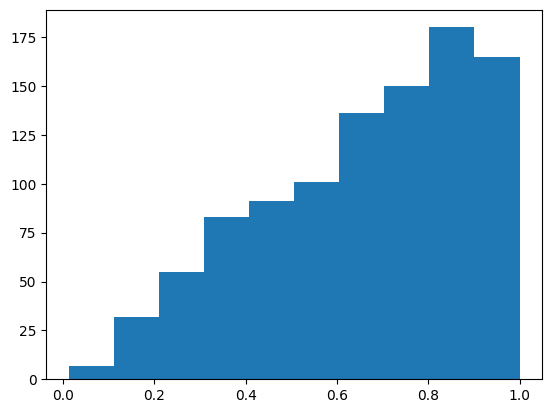

In [480]:
import matplotlib.pyplot as plt

plt.hist(np.random.beta(2, 1, size=1000))

In [481]:
np.random.beta(2, 1, size=1000)

array([0.80768494, 0.33423433, 0.12927168, 0.50640959, 0.6326076 ,
       0.79405658, 0.84282706, 0.48223917, 0.55699613, 0.46025291,
       0.90541237, 0.88124285, 0.91768566, 0.62200519, 0.34123168,
       0.29691024, 0.95060592, 0.96690523, 0.62884221, 0.22799833,
       0.8806903 , 0.42772937, 0.97150969, 0.49629193, 0.83736454,
       0.4631319 , 0.6743654 , 0.34284341, 0.81226154, 0.3870006 ,
       0.80449439, 0.82085359, 0.1525289 , 0.54984277, 0.61495267,
       0.58752684, 0.95856499, 0.9207567 , 0.14803725, 0.41322459,
       0.77694327, 0.77379271, 0.56625825, 0.88427336, 0.95489032,
       0.88935586, 0.79620063, 0.36875745, 0.92011235, 0.45032258,
       0.3877987 , 0.93038762, 0.88005733, 0.98654718, 0.76639457,
       0.69085242, 0.56176692, 0.99942633, 0.82956828, 0.78461978,
       0.75844553, 0.5693119 , 0.19818988, 0.77585582, 0.70854995,
       0.53725765, 0.70853926, 0.894412  , 0.75665194, 0.37708392,
       0.79412887, 0.81438788, 0.92632642, 0.69464557, 0.70728